# Data import

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Read training data from CSV
train_data_raw = pd.read_csv('resources/normal.csv')
train_data_raw.shape

(6613, 26)

In [3]:
# Read validation data from CSV
validate_data_raw = pd.read_csv('resources/verify.csv')
validate_data_raw.shape

(5200, 26)

In [4]:
# Choose only columns containing features we want to use for training
feature_list = [" LinAccX (g)"]
features = len(feature_list)
train_data_selected = train_data_raw[feature_list].as_matrix()
validate_data_selected = validate_data_raw[feature_list].as_matrix()

# Data visualization

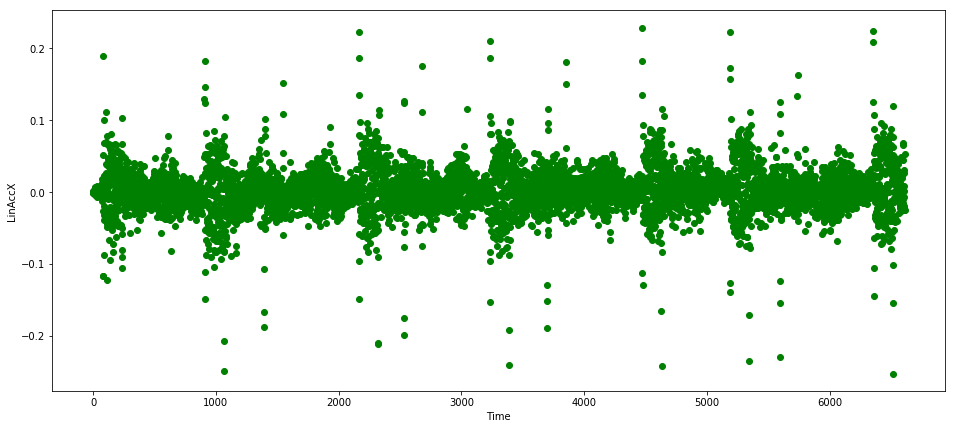

In [5]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(16, 7)

plt.plot(range(len(train_data_raw)), train_data_raw[feature_list], "go")
plt.ylabel('LinAccX')
plt.xlabel('Time')
plt.show()

# Multi layer perceptron

## Data preparation

In [6]:
# Convert a dataset into a windowed format - append *window - 1* records to the back of each record. 
# For example:
# window = 2
# dataset =
# [
#  [1, 2, 3],
#  [2, 3, 4],
#  [5, 6, 7]
# ]
#
# Will result in:
# [
#  [0, 0, 0, 1, 2, 3], # padding with 0 since there were no observations before the first one
#  [1, 2, 3, 2, 3, 4],
#  [2, 3, 4, 5, 6, 7]
# ]
def prepare_dataset(dataset, window):
    windowed_data = []
    for i in range(len(dataset)):
        start = i + 1 - window if i + 1 - window >= 0 else 0
        observation = dataset[start : i + 1,]
        to_pad = (window - i - 1 if i + 1 - window < 0 else 0) * features
        observation = observation.flatten()
        observation = np.lib.pad(observation, (to_pad, 0), 'constant', constant_values=(0, 0))
        windowed_data.append(observation)
    return np.array(windowed_data)
    
# Window size - the bigger this value is, the longer our network will "retain" past information i.e. it will take longer
# for newer state to become significant but it will also mean we will use the time dependency factor more into account.
window = 25

# Convert our data into windowed formats
data_train = prepare_dataset(train_data_selected, window)
data_validate = prepare_dataset(validate_data_selected, window)

In [7]:
from __future__ import print_function
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

In [8]:
# Split the data into training and testing sets
# When working with time-series data you usually should not do random samplic as temoporal dependency between observations
# is of great important. The simples way to do a split in such a situation is just find a split point in the data
# and use everything left to that point as training and the rest as test data.
rows = len(data_train)
split_factor = 0.8
train = data_train[0:int(rows*split_factor)]
test = data_train[int(rows*split_factor):]

In [9]:
# Create an iterator, which will feed our data in a batched fashion into MXNet
batch_size = 256
batches = int(len(train) / batch_size)
train_iter = mx.io.NDArrayIter(
    data={'data': train}, 
    label={'data': train},
    batch_size=batch_size, shuffle=False, 
    last_batch_handle='pad')
test_iter = mx.io.NDArrayIter(
    data={'data': test}, 
    label={'data': test},
    batch_size=batch_size, shuffle=False, 
    last_batch_handle='pad')

## Network modelling

In [10]:
ctx = mx.gpu() # use mx.cpu() on machines with no GPU

In [11]:
# For this network we will use our windowed data representation, so each record will actually contain all the features
# from *window* number of records hence or total input size:
total_features = window * features

# Placeholder for the input data which will be used for training
data = mx.symbol.Variable('data')
# Connection between input and first hidden layer
fc1 = mx.symbol.FullyConnected(data, name='fc1', num_hidden=16)
# Activation funtion after our hidden layer
act1 = mx.symbol.Activation(fc1, name='act1', act_type='tanh')
dropout1 = mx.symbol.Dropout(act1, p = 0.25)

fc2 = mx.symbol.FullyConnected(dropout1, name='fc2', num_hidden=8)
act2 = mx.symbol.Activation(fc2, name='act2', act_type='tanh')
dropout2 = mx.symbol.Dropout(act2, p = 0.25)

fc3 = mx.symbol.FullyConnected(dropout2, name='fc3', num_hidden=16)
act3 = mx.symbol.Activation(fc3, name='act3', act_type='tanh')
dropout3 = mx.symbol.Dropout(act3, p = 0.25)

# Connection between hidden layer and our output layer - since it is an autoencoder we want the size to be same as input size
out = mx.symbol.FullyConnected(dropout3, name='fc4', num_hidden=total_features)
# Linear regression output allows us to easily calculate RMSE between output and input layers and use it as loss
loss = mx.symbol.LinearRegressionOutput(data=out, label=data)

model = mx.mod.Module(
    loss,
    context = ctx, 
    data_names=['data'],
    label_names=['data']
)

In [12]:
# Custom logger handler to intercept training and validation RMSE
# MXNet by default only exposes training RMSE through callbacks
import logging
logging.getLogger().setLevel(logging.DEBUG)

train_rmse = []
test_rmse = []

class RMSEHandler(logging.Handler):
    def emit(self, record):
        log_entry = self.format(record)
        if "Train-rmse" in log_entry:
            train_rmse.append( float( log_entry.split("=")[1] ) )
        elif "Validation-rmse" in log_entry:
            test_rmse.append( float( log_entry.split("=")[1] ) )

logging.getLogger().handlers = []
logging.getLogger().addHandler(RMSEHandler())

## Training

In [13]:
%%time 
model.fit(train_iter, test_iter,
          num_epoch = 100, 
          eval_metric='rmse',
          optimizer='adam',
          optimizer_params={'learning_rate':0.001},
          initializer = mx.init.Xavier() # Non standard initializer for weights etc.
)

CPU times: user 1min 4s, sys: 1.42 s, total: 1min 6s
Wall time: 6.59 s


In [14]:
# Plot the training vs test rmse
def plot_errors(train_rmse, test_rmse):
    epochs = range(len(train_rmse))
    plt.plot(epochs, train_rmse, label='Train')
    plt.plot(epochs, test_rmse, label='Test')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

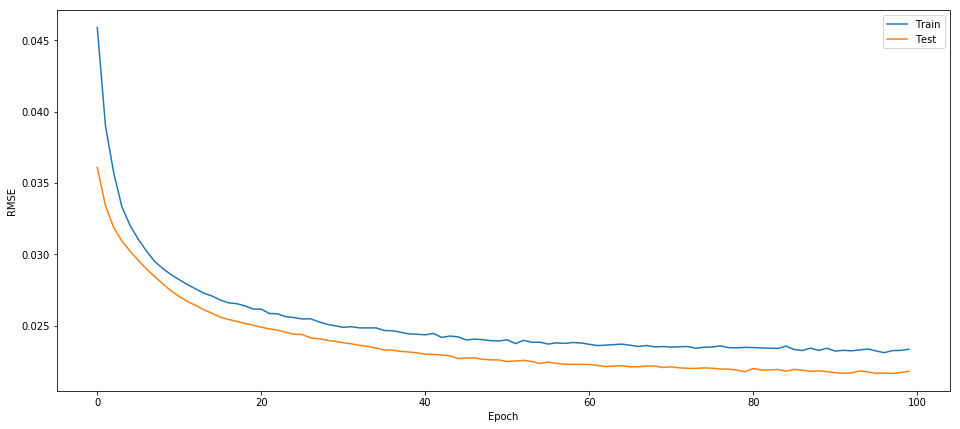

In [15]:
plot_errors(train_rmse, test_rmse)

## Validation data

In [16]:
# Helper method calculating RMSE between two array-like objects
def rmse(targets, predictions):
     return np.sqrt(np.mean((predictions-targets)**2))

predictions_iter = mx.io.NDArrayIter(
    data={'data': data_train}, 
    label={'data': data_train},
    batch_size=batch_size, shuffle=False, 
    last_batch_handle='pad')
    
# Make predictions for our training data so we can calculate the anomaly threshold
predictions = model.predict(predictions_iter).asnumpy()
# Even though, we are using LinearRegressionOutput for training, MXNet returns us as output the previous layer,
# meaning the one with *total_features* neurons. We have to compute the RMSE for each record ourselves.
errors = list(map(lambda e: rmse(e[0], e[1]), zip(data_train, predictions)))
# We will treat as anomalies records, for which error is far from the mean. We'll consider only the furthest 0.1%
# this means records which are 3 standard deviations from the mean
threshold =  np.mean(errors) + 3*np.std(errors)

In [17]:
# Prepare the validation dataset for predictions
validation_iter = mx.io.NDArrayIter(
    data={'data': data_validate}, 
    label={'data': data_validate},
    batch_size=64, shuffle=False, 
    last_batch_handle='pad')

validation_predictions = model.predict(validation_iter).asnumpy()
errors = list(map(lambda e: rmse(e[0], e[1]), zip(data_validate, validation_predictions)))
# Every record, for which the prediction RMSE is bigger than the threshold is considered an anomaly
anomaly = list(map(lambda v: v > threshold, errors))

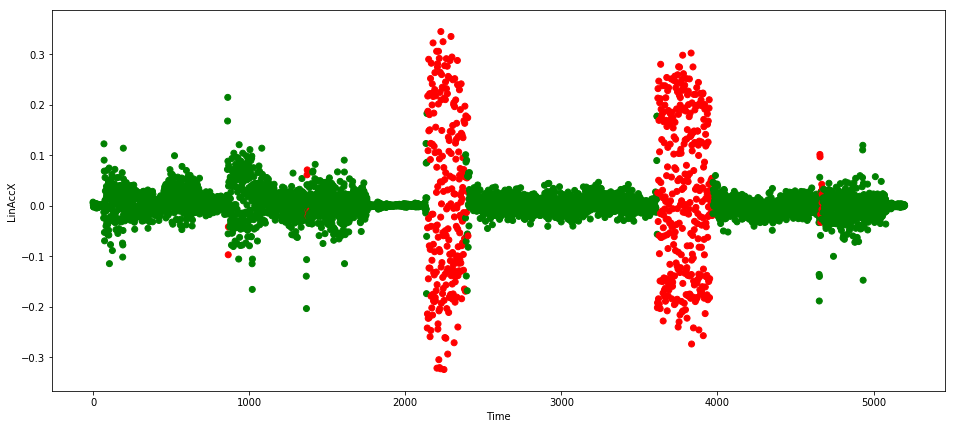

In [18]:
# Result visualization
anomaly_col = list(map(lambda v: "red" if v else "green", anomaly))
plt.scatter(range(len(validate_data_raw)), validate_data_raw[" LinAccX (g)"], c=anomaly_col)
plt.ylabel('LinAccX')
plt.xlabel('Time')
plt.show()

# Long-short term memory

## Data preparation

In [19]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd
from mxnet import gluon
import numpy as np

In [20]:
# Setup iterators for Gluon to feed our model with batched data during training
batch_size = 128

# Split the data into train and test
rows = len(data_train)
split_factor = 0.8
train = train_data_selected.astype(np.float32)[0:int(rows*split_factor)]
test = train_data_selected.astype(np.float32)[int(rows*split_factor):]

train_data = mx.gluon.data.DataLoader(train, batch_size, shuffle=False)
test_data = mx.gluon.data.DataLoader(test, batch_size, shuffle=False)

## Network modelling

In [21]:
ctx = mx.gpu() # use mx.cpu() on machines with no GPU

In [22]:
model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(window, dropout=0.35))
    model.add(mx.gluon.rnn.LSTM(features))

# Use the non default Xavier parameter initializer
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

# Use Adam optimizer for training
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.01})

# Similarly to previous example we will use L2 loss for evaluation
L = gluon.loss.L2Loss()

## Training

In [23]:
# Evaluation function
def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,features,1))
        label = data
        output = model(data)
        loss = L(output, label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return loss_avg

In [24]:
%%time
epochs = 25

all_train_rmse = []
all_test_rmse = []

# Gluon training loop
for e in range(epochs):
    for i, data in enumerate(train_data):
        data = data.as_in_context(ctx).reshape((-1,features,1))
        label = data
        with autograd.record():
            output = model(data)
            loss = L(output, label)
        loss.backward()
        trainer.step(batch_size)
    
    train_rmse = evaluate_accuracy(train_data, model, L)
    test_rmse = evaluate_accuracy(test_data, model, L)
    all_train_rmse.append(train_rmse)
    all_test_rmse.append(test_rmse)

CPU times: user 28.5 s, sys: 9.48 s, total: 37.9 s
Wall time: 32.1 s


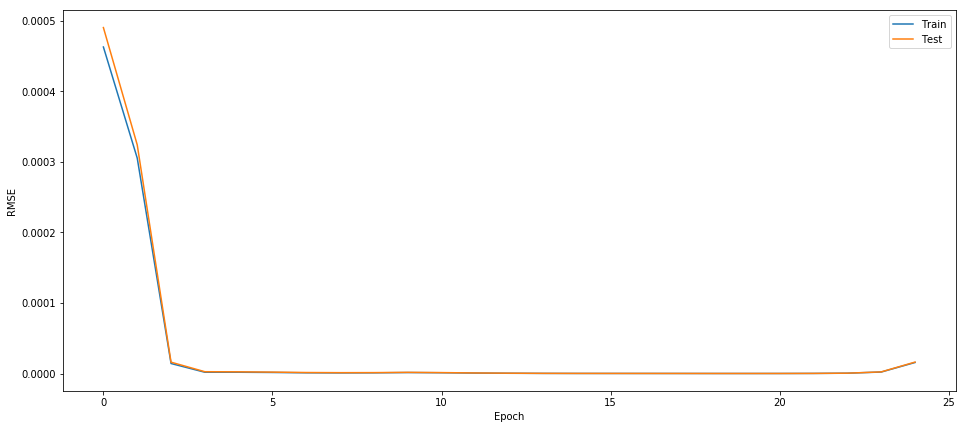

In [25]:
plot_errors(all_train_rmse, all_test_rmse)

In [26]:
# Helper method running predictions in a batched fashion
def predict(to_predict, L):
    predictions = []
    for i, data in enumerate(to_predict):
        input = data.as_in_context(ctx).reshape((-1,features,1))
        out = model(input)
        prediction = L(out, input).asnumpy().flatten()
        predictions = np.append(predictions, prediction)
    return predictions

In [27]:
train_data = mx.gluon.data.DataLoader(train_data_selected.astype(np.float32), batch_size, shuffle=False)

train_predictions = predict(train_data, L)
threshold =  np.mean(train_predictions) + 3*np.std(train_predictions)

## Validation

In [28]:
validate_data = mx.gluon.data.DataLoader(validate_data_selected.astype(np.float32), batch_size, shuffle=False)

validation_predictions = predict(validate_data, L)

In [29]:
anomaly = list(map(lambda v: v > threshold, validation_predictions))

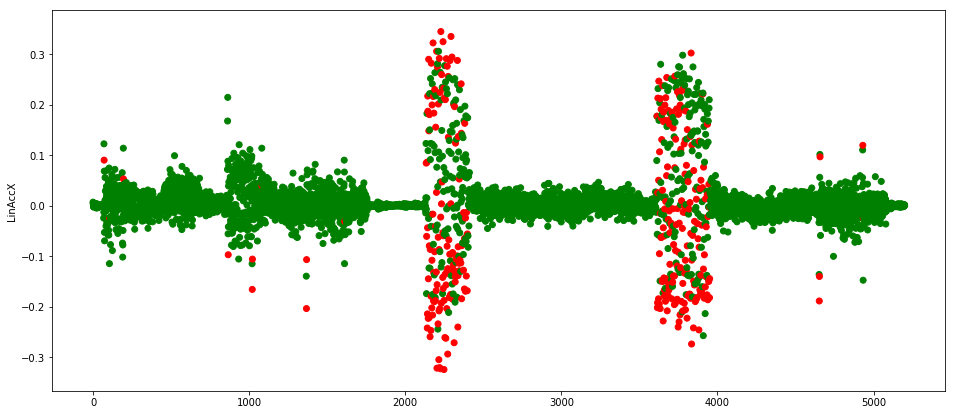

In [30]:
# Result visualization
anomaly = list(map(lambda v: "red" if v else "green", anomaly))
plt.scatter(list(range(len(validate_data_raw[" LinAccX (g)"]))), validate_data_raw[" LinAccX (g)"], c=anomaly)
plt.ylabel('LinAccX')
plt.show()